In [2]:
%%html
<img src="./figs/happy_hands.jpg" width = "100%" />

# What Made You Happy Today?
What made your day? Had some good news? Seen something beautiful? Simply woken up with a song in your heart? Happiness comes and goes, and sometimes no one including ourselves don’t know about it. Using the HappyDB, which is “a corpus of 100,000 crowd-sourced happy moments”, let’s find out what factors can make people feel happy.

## Import

In [3]:
import pandas as pd
import numpy as np
import country_converter as coco

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
plt.style.use('classic')
sns.set_style('whitegrid')
%matplotlib inline

## Load Data

In [9]:
df = pd.read_csv('../data/processed_data.csv')
df_demo = pd.read_csv('../data/demographic.csv')

In [18]:
df.head()

hmid   wid reflection_period  \
0  27673  2053               24h   
1  27674     2               24h   
2  27675  1936               24h   
3  27676   206               24h   
4  27677  6227               24h   

                                         original_hm  \
0  i went on a successful date with someone i fel...   
1  i was happy when my son got 90% marks in his e...   
2       i went to the gym this morning and did yoga.   
3  we had a serious talk with some friends of our...   
4  i went with grandchildren to butterfly display...   

                                          cleaned_hm  modified  num_sentence  \
0  i went on a successful date with someone i fel...      True             1   
1  i was happy when my son got 90% marks in his e...      True             1   
2       i went to the gym this morning and did yoga.      True             1   
3  we had a serious talk with some friends of our...      True             2   
4  i went with grandchildren to butterfly display...      True             1   

  ground_truth_category predicted_category  \
0                   NaN          affection   
1                   NaN          affection   
2                   NaN           exercise   
3               bonding            bonding   
4                   NaN          affection   

                                                text  
0               successful date sympathy connection   
1                              son mark examination   
2                                  gym morning yoga   
3  serious talk friend flaky lately understood ev...  
4   grandchild butterfly display crohn conservatory

In [19]:
df_demo.head()

wid   age country gender  marital parenthood
0    1  37.0     USA      m  married          y
1    2  29.0     IND      m  married          y
2    3    25     IND      m   single          n
3    4    32     USA      m  married          y
4    5    29     USA      m  married          y

## Part 1: Preprocess data

### Merge datasets

In [20]:
df_new = pd.merge(df, df_demo, on='wid')

### Check data

In [21]:
df_new.head()

hmid   wid reflection_period  \
0  27673  2053               24h   
1  27873  2053               24h   
2  28073  2053               24h   
3  33522  2053               24h   
4  34522  2053               24h   

                                         original_hm  \
0  i went on a successful date with someone i fel...   
1  i played a new game that was fun and got to en...   
2  i listened to some music and heard an entire a...   
3                 went to see a movie with my friend   
4               played guitar, learning a song on it   

                                          cleaned_hm  modified  num_sentence  \
0  i went on a successful date with someone i fel...      True             1   
1  i played a new game that was fun and got to en...      True             1   
2  i listened to some music and heard an entire a...      True             1   
3                 went to see a movie with my friend      True             1   
4               played guitar, learning a song on it      True             1   

  ground_truth_category predicted_category  \
0                   NaN          affection   
1                   NaN            leisure   
2                   NaN            leisure   
3                   NaN            bonding   
4                   NaN            leisure   

                                             text age country gender marital  \
0            successful date sympathy connection   35     USA      m  single   
1             played new game fun enjoy mechanic   35     USA      m  single   
2  listened music heard entire album hadnt heard   35     USA      m  single   
3                               see movie friend   35     USA      m  single   
4                    played guitar learning song   35     USA      m  single   

  parenthood  
0          n  
1          n  
2          n  
3          n  
4          n

In [663]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100535 entries, 0 to 100534
Data columns (total 15 columns):
hmid                     100535 non-null int64
wid                      100535 non-null int64
reflection_period        100535 non-null object
original_hm              100535 non-null object
cleaned_hm               100535 non-null object
modified                 100535 non-null bool
num_sentence             100535 non-null int64
ground_truth_category    14125 non-null object
predicted_category       100535 non-null object
text                     100521 non-null object
age                      100442 non-null object
country                  100332 non-null object
gender                   100456 non-null object
marital                  100378 non-null object
parenthood               100457 non-null object
dtypes: bool(1), int64(3), object(11)
memory usage: 11.6+ MB


In [22]:
df_new['age'] = df_new['age'].replace("prefer not to say", np.nan)
df_new['age'] = df_new['age'].replace("čá", np.nan)
df_new['age'] = df_new['age'].replace("60yrs", 60)
df_new['age'] = pd.to_numeric(df_new['age'])

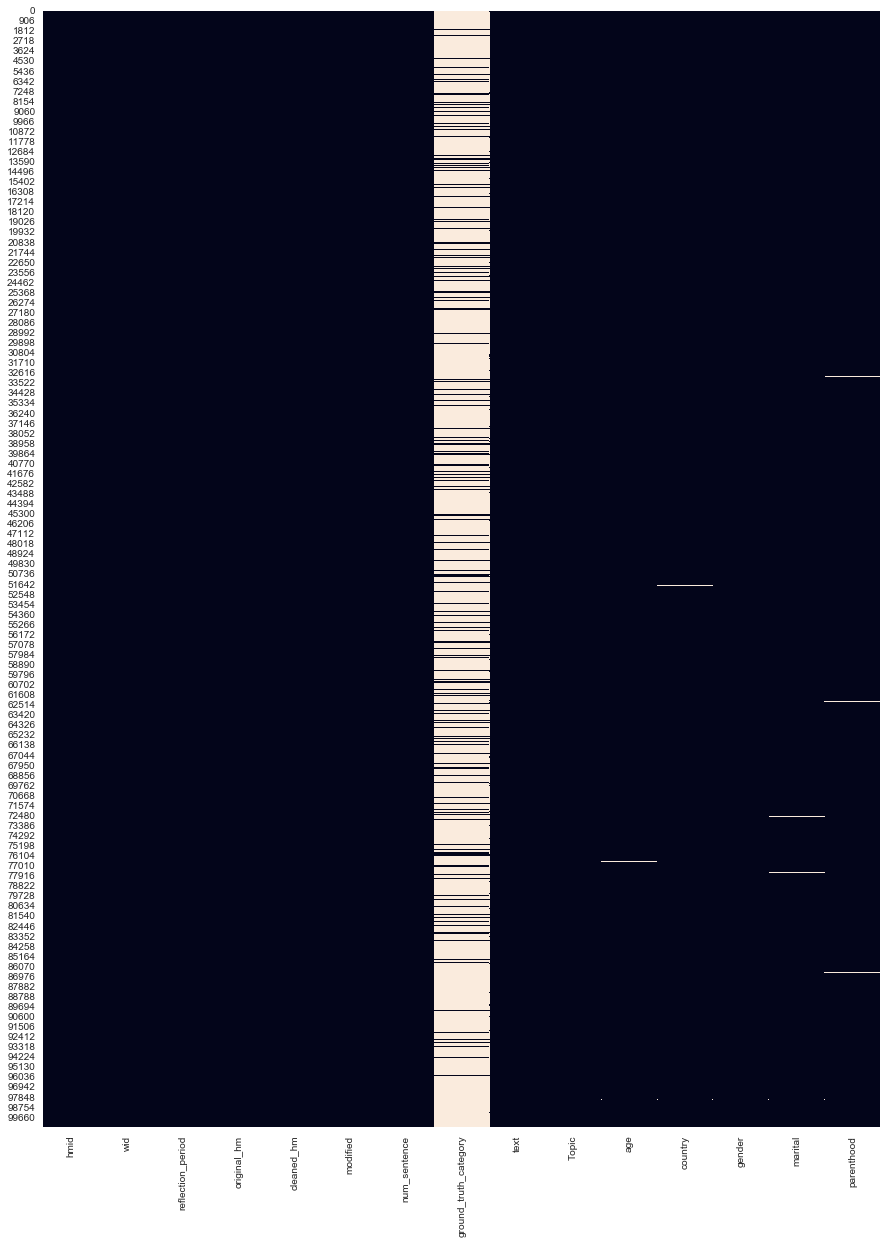

In [109]:
plt.figure(figsize=(15,20))
sns.heatmap(df_new.isnull(), cbar=False)

In [7]:
df_new.isna().apply(lambda x: x.value_counts(), axis=0)

hmid       wid  reflection_period  original_hm  cleaned_hm  \
False  100535.0  100535.0           100535.0     100535.0    100535.0   
True        NaN       NaN                NaN          NaN         NaN   

       modified  num_sentence  ground_truth_category  predicted_category  \
False  100535.0      100535.0                  14125            100535.0   
True        NaN           NaN                  86410                 NaN   

         text     age  country  gender  marital  parenthood  
False  100519  100397   100332  100456   100378      100457  
True       16     138      203      79      157          78

Too many values in column *ground_truth_category* drop it.

In [23]:
df_new = df_new.drop(columns='ground_truth_category', axis=1)

In [24]:
df_new['reflection_period'].value_counts()

3m     50704
24h    49831
Name: reflection_period, dtype: int64

In [668]:
df_new['predicted_category'].value_counts()

affection           34168
achievement         33993
enjoy_the_moment    11144
bonding             10727
leisure              7458
nature               1843
exercise             1202
Name: predicted_category, dtype: int64

In [669]:
df_new['gender'].value_counts()

m    57690
f    42069
o      697
Name: gender, dtype: int64

In [670]:
df_new['marital'].value_counts()

single       54106
married      41343
divorced      3803
separated      649
widowed        477
Name: marital, dtype: int64

In [671]:
df_new['parenthood'].value_counts()

n    60937
y    39520
Name: parenthood, dtype: int64

In [672]:
df_new.describe()

hmid            wid   num_sentence            age
count  100535.000000  100535.000000  100535.000000  100397.000000
mean    78213.756722    2746.619028       1.340767      32.540036
std     29178.959001    3535.010347       1.297159      11.075900
min     27673.000000       1.000000       1.000000       2.000000
25%     52941.500000     410.000000       1.000000      26.000000
50%     78204.000000    1125.000000       1.000000      30.000000
75%    103490.500000    3507.000000       1.000000      36.000000
max    128766.000000   13839.000000      69.000000     233.000000

In [25]:
df_clean = df_new[df_new['gender'] != 'o']

In [26]:
df_clean.loc[df_clean['age'] == 227, 'age'] = 27
df_clean.loc[df_clean['age'] == 233, 'age'] = 23

In [27]:
df_clean[df_clean['age'] > 100]

Empty DataFrame
Columns: [hmid, wid, reflection_period, original_hm, cleaned_hm, modified, num_sentence, predicted_category, text, age, country, gender, marital, parenthood]
Index: []

### Create new feature

#### num_words

In [28]:
col_names = df_clean.columns.tolist()
col_names.insert(col_names.index('predicted_category'), 'num_words')
df_clean = df_clean.reindex(columns=col_names)

In [29]:
df_clean['num_words'] = df_clean['original_hm'].apply(lambda x: len(x))

#### age_group

In [30]:
df_clean.loc[df_clean['age'].notnull(), 'age_group'] = ['[0, 20)' if x < 20 
                                                        else ('[20, 30)' if (20 <= x and x < 30) 
                                                              else ('[30, 40)' if (30 <= x and x < 40) 
                                                                    else ('[40, 50)' if (40 <= x and x < 50) 
                                                                          else ('[50, 100)')))) for x in df_clean.loc[df_clean['age'].notnull(), 'age']]

In [31]:
df_clean.loc[df_clean['age'].isnull(), 'age_group'] = 'NaN'

#### region 

In [32]:
%%capture
df_clean['region'] = df_clean['country'].apply(lambda x: coco.convert(names=x, to='continent', not_found=None))

In [1150]:
df_clean.head()

hmid   wid reflection_period  \
0  27673  2053               24h   
1  27873  2053               24h   
2  28073  2053               24h   
3  33522  2053               24h   
4  34522  2053               24h   

                                         original_hm  \
0  i went on a successful date with someone i fel...   
1  i played a new game that was fun and got to en...   
2  i listened to some music and heard an entire a...   
3                 went to see a movie with my friend   
4               played guitar, learning a song on it   

                                          cleaned_hm  modified  num_sentence  \
0  i went on a successful date with someone i fel...      True             1   
1  i played a new game that was fun and got to en...      True             1   
2  i listened to some music and heard an entire a...      True             1   
3                 went to see a movie with my friend      True             1   
4               played guitar, learning a song on it      True             1   

   num_words  num_words predicted_category  \
0         77         77          affection   
1         70         70            leisure   
2         88         88            leisure   
3         34         34            bonding   
4         36         36            leisure   

                                             text   age country gender  \
0            successful date sympathy connection   35.0     USA      m   
1             played new game fun enjoy mechanic   35.0     USA      m   
2  listened music heard entire album hadnt heard   35.0     USA      m   
3                               see movie friend   35.0     USA      m   
4                    played guitar learning song   35.0     USA      m   

  marital parenthood age_group   region  
0  single          n  [30, 40)  America  
1  single          n  [30, 40)  America  
2  single          n  [30, 40)  America  
3  single          n  [30, 40)  America  
4  single          n  [30, 40)  America

## Part 2: Preliminary data analysis

## predicted_category

In [650]:
cnt_topic = df_clean['predicted_category'].value_counts().sort_values(ascending=True)

([<matplotlib.axis.YTick at 0x1ace470780>,
 <a list of 7 Text yticklabel objects>)

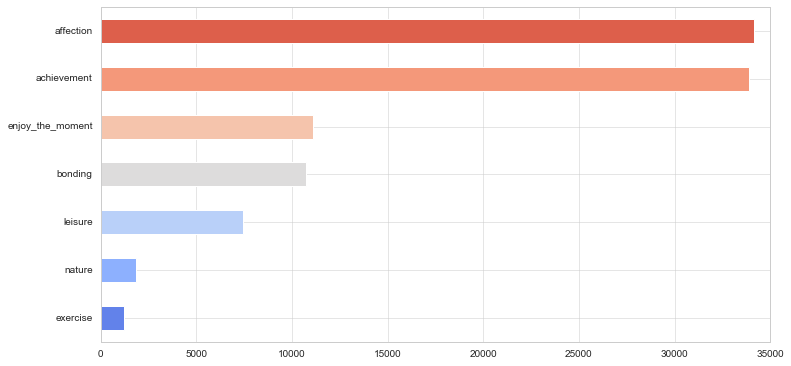

In [651]:
plt.figure(figsize=(12,6))
cnt_topic.plot(kind='barh', color=sns.color_palette("coolwarm", 7))
plt.yticks(range(len(cnt_topic)), cnt_topic.index.tolist())

The ranking shows that *affection* and *achievement* are top 2 reasons that lead to happiness, running far ahead of the rest 5 categories. And obviously, *exercise* is the least mentioned reason that makes people happy.

In [84]:
df_all = df_clean.astype(str)
df_affection = df_clean[df_clean['predicted_category'] == 'affection'].astype(str)
df_achievement = df_clean[df_clean['predicted_category'] == 'achievement'].astype(str)
df_enjoy = df_clean[df_clean['predicted_category'] == 'enjoy_the_moment'].astype(str)
df_bonding = df_clean[df_clean['predicted_category'] == 'bonding'].astype(str)
df_leisure = df_clean[df_clean['predicted_category'] == 'leisure'].astype(str)
df_nature = df_clean[df_clean['predicted_category'] == 'nature'].astype(str)
df_exercise = df_clean[df_clean['predicted_category'] == 'exercise'].astype(str)

In [85]:
text_all = ""
for i in df_all['text'].iteritems():
    text_all = text_all + "".join(str(x) for x in i[1])

text_affection = ""
for i in df_affection['text'].iteritems():
    text_affection = text_affection + "".join(str(x) for x in i[1])

text_achievement = ""
for i in df_achievement['text'].iteritems():
    text_achievement = text_achievement + "".join(str(x) for x in i[1])
    
text_enjoy = ""
for i in df_enjoy['text'].iteritems():
    text_enjoy = text_enjoy + "".join(str(x) for x in i[1])

text_bonding = ""
for i in df_bonding['text'].iteritems():
    text_bonding = text_bonding + "".join(str(x) for x in i[1])

text_leisure = ""
for i in df_leisure['text'].iteritems():
    text_leisure = text_leisure + "".join(str(x) for x in i[1])

text_nature = ""
for i in df_nature['text'].iteritems():
    text_nature = text_nature + "".join(str(x) for x in i[1])

text_exercise = ""
for i in df_exercise['text'].iteritems():
    text_exercise = text_exercise + "".join(str(x) for x in i[1])

In [808]:
wc_all = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_all)

wc_affection = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_affection)

wc_achievement = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_achievement)

wc_enjoy = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_enjoy)

wc_bonding = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_bonding)

wc_leisure = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_leisure)

wc_nature = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_nature)

wc_exercise = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_exercise)

Text(0.5, 1, 'Exercise')

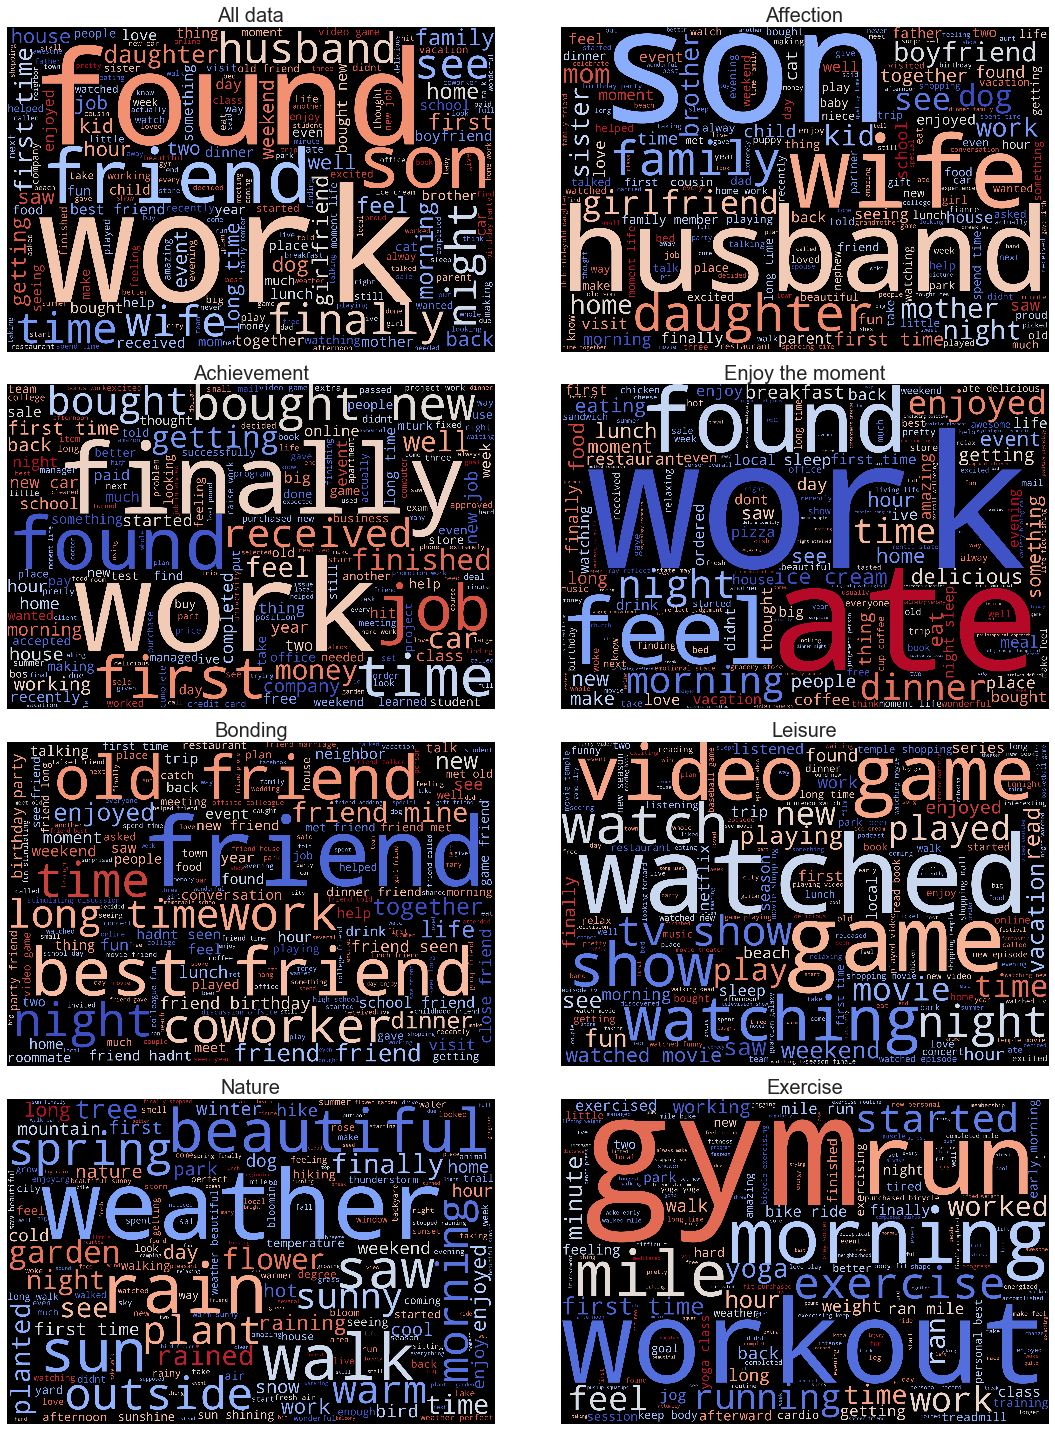

In [809]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(18,20))
fig.tight_layout()
plt.subplots_adjust(wspace =-0.2, hspace =0.1)
ax[0,0].imshow(wc_all, interpolation = 'bilinear')
ax[0,1].imshow(wc_affection, interpolation = 'bilinear')
ax[1,0].imshow(wc_achievement, interpolation = 'bilinear')
ax[1,1].imshow(wc_enjoy, interpolation = 'bilinear')
ax[2,0].imshow(wc_bonding, interpolation = 'bilinear')
ax[2,1].imshow(wc_leisure, interpolation = 'bilinear')
ax[3,0].imshow(wc_nature, interpolation = 'bilinear')
ax[3,1].imshow(wc_exercise, interpolation = 'bilinear')
ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")
ax[2,0].axis("off")
ax[2,1].axis("off")
ax[3,0].axis("off")
ax[3,1].axis("off")
ax[0,0].set_title("All data", fontsize=20)
ax[0,1].set_title("Affection", fontsize=20)
ax[1,0].set_title("Achievement", fontsize=20)
ax[1,1].set_title("Enjoy the moment", fontsize=20)
ax[2,0].set_title("Bonding", fontsize=20)
ax[2,1].set_title("Leisure", fontsize=20)
ax[3,0].set_title("Nature", fontsize=20)
ax[3,1].set_title("Exercise", fontsize=20)

From these scatterplots we can make a few observations:

- Overall speaking, the most frequentist words occur in the submissions of happy moment is work, friend and family members.
- Happy moments predicted as *affection* often involve the home and family members settings.
- Happy moments predicted as *achievement* most involve work and job. Finally, first time and finished also occur frequently, indicating a sense of achievement.
- Happy moments predicted as *enjoy_the _moment* most often involve work, and especially refer to dinnertime as the time when the happy moment occurred according to words such as ate, dinner and restaurant. 
- Happy moments predicted as *bonding* understandably most involve friend and coworker.
- Happy moments predicted as *leisure* most happen when watching game, video and show.
- Happy moments predicted as *nature* most contain words descrbing the weather and botany.
- Happy moments predicted as *exercise* most involve gym, workout and names of the name of the exercise.

Next, let's take a look at each subset of data to explore demographics of respondents.

### Gender

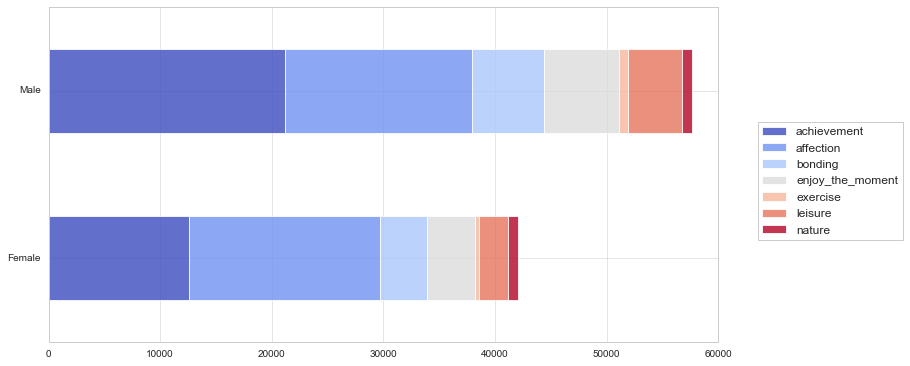

In [679]:
ct_gender = pd.crosstab(df_clean['gender'], df_clean['predicted_category'])
ct_gender.plot.barh(stacked=True, alpha=0.8, figsize=(12,6), cmap='coolwarm')
plt.ylabel('')
plt.yticks(range(2), ('Female', 'Male'))
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.48))

The category makeup of those happy events submitted by males are predominantly related to topic *achievement*. While females feel happy majorly because of *affection*. This pointis out the natural difference between genders women are more emontional and men tend to value their career and achievement more.
However, overall speaking, *achievement* and *affection* are the most frequentist mentioned topics when people talk about happy moment. *exercise* runs the least.

In [787]:
df_m = df_clean[df_clean['gender'] == 'm'].astype(str)
df_f = df_clean[df_clean['gender'] == 'f'].astype(str)

In [788]:
text_m = ""
for i in df_m['text'].iteritems():
    text_m = text_m + "".join(str(x) for x in i[1])

text_f = ""
for i in df_f['text'].iteritems():
    text_f = text_f + "".join(str(x) for x in i[1])

In [824]:
m_mask = np.array(Image.open(r'../figs/wc_m.jpg'))
f_mask = np.array(Image.open(r'../figs/wc_f.jpg'))

In [837]:
wc_m = WordCloud(
    background_color = 'black',
    stopwords = STOPWORDS,
    ranks_only = True,
    colormap = 'coolwarm',
    max_words = 300,
    max_font_size = 300,
    mask = m_mask).generate(text_m)

wc_f = WordCloud(
    background_color = 'black',
    ranks_only = True,
    colormap = 'coolwarm',
    max_words = 300,
    max_font_size = 300,
    stopwords = STOPWORDS,
    mask = f_mask).generate(text_f)

(-0.5, 2575.5, 2927.5, -0.5)

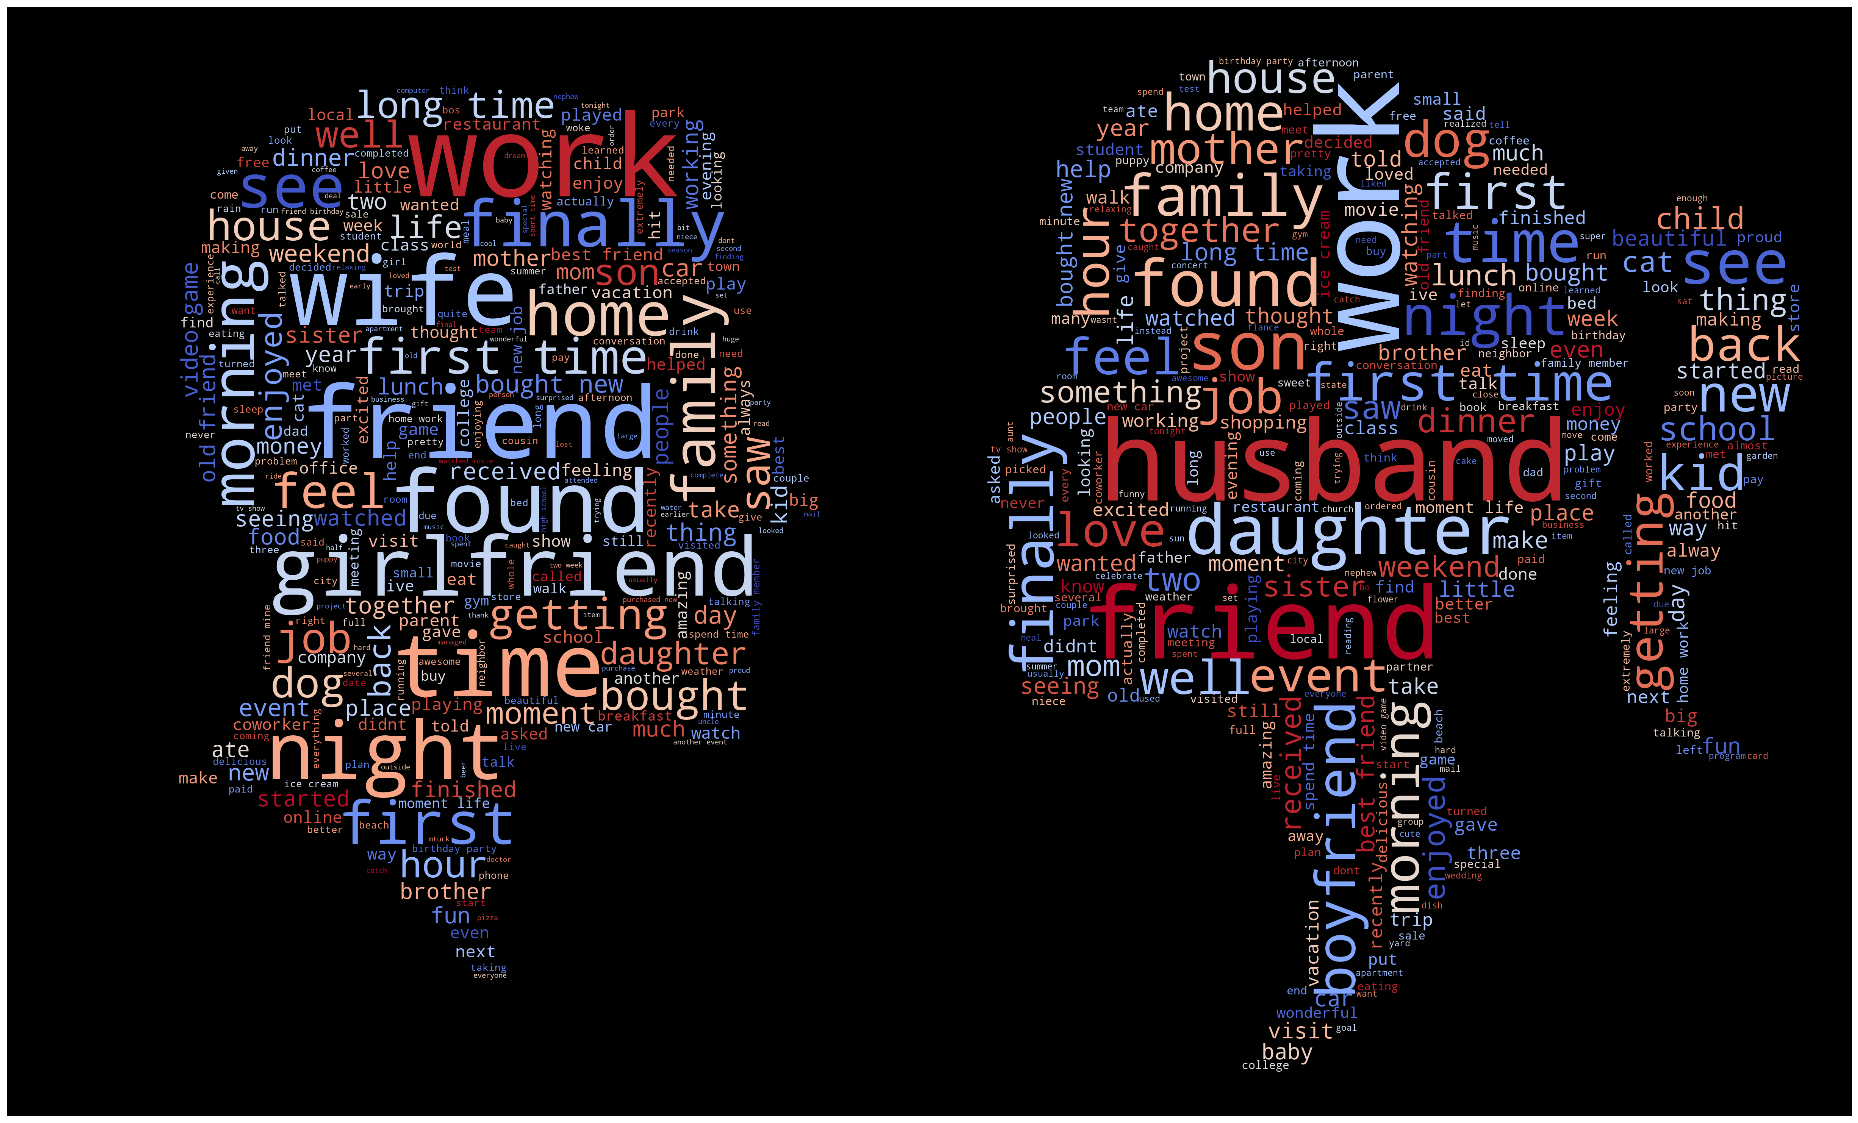

In [838]:
fig, ax = plt.subplots(figsize=(30, 16), nrows=1, ncols=2)
fig.tight_layout()
plt.subplots_adjust(wspace =-0.3)
ax[0].imshow(wc_m)
ax[1].imshow(wc_f)
ax[0].axis("off")
ax[1].axis("off")

There's no much difference between male ans female in terms of happy moments they submitted. The top three words for both gender are work, friend and wife/husband. The main difference is that females pay more attention on family and children while males seem to enjoy more through romantic relationship. Also notice that some word which are unique in each gender group such as video game for males and shopping for females. Basically, this is consistent with our life experience.

### Age

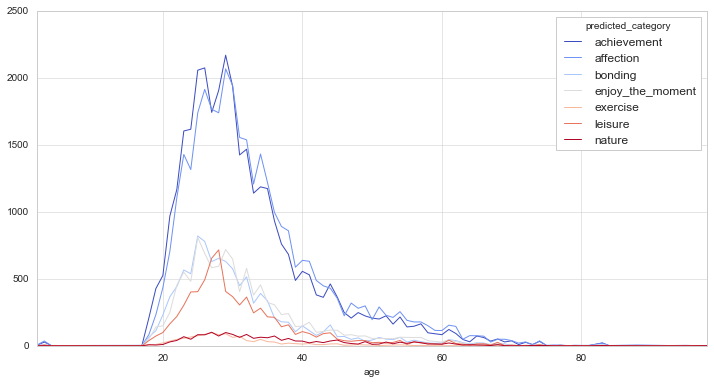

In [547]:
ct_age = pd.crosstab(df_clean['age'], df_clean['predicted_category'])
ct_age.plot(colormap='coolwarm', figsize=(12,6))

Most of the people who participated in this survey age between 20 and 40. And during their early 20, a majority consider *achievement* as the primary source of happy moments. As they get older, *affection* turns out to be dominant.

In [46]:
grid_df = df_clean[df_clean['age_group'] != 'NaN']

Text(0.5, 5.799999999999965, 's')

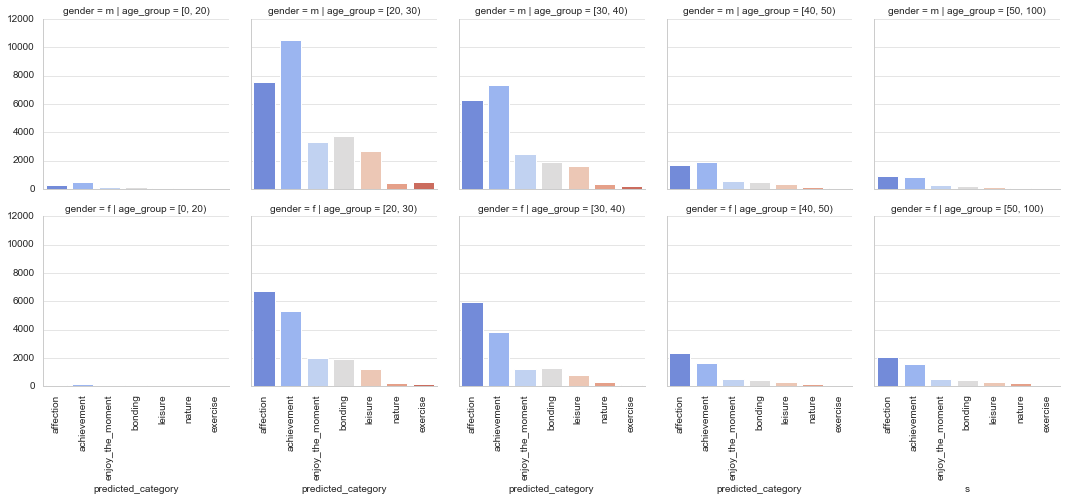

In [123]:
g = sns.FacetGrid(grid_df, col='age_group', row='gender', 
                  col_order=['[0, 20)', '[20, 30)', '[30, 40)', '[40, 50)', '[50, 100)'])
g = g.map(sns.countplot, 'predicted_category', palette='coolwarm', 
          order=['affection', 'achievement', 'enjoy_the_moment', 'bonding', 'leisure', 'nature', 'exercise'])
for ax in g.axes.flat:
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=90)

At the same age, males and females tend to show some differences. Aged between 20 and 30, males are more likely feel happy due to *achievement* while females are more happy with *affection*. With the age getting older, the pattern for females doesn't change much. For males, the gap between number of submission under *affection* category and *achievement* category gets narrow and eliminates eventually. 

In [80]:
df_0 = df_clean[df_clean['age_group'] == '[0, 20)'].astype(str)
df_1 = df_clean[df_clean['age_group'] == '[20, 30)'].astype(str)
df_2 = df_clean[df_clean['age_group'] == '[30, 40)'].astype(str)
df_3 = df_clean[df_clean['age_group'] == '[40, 50)'].astype(str)
df_4 = df_clean[df_clean['age_group'] == '[50, 100)'].astype(str)

In [81]:
text_0 = ""
for i in df_0['text'].iteritems():
    text_0 = text_0 + "".join(str(x) for x in i[1])
    
text_1 = ""
for i in df_1['text'].iteritems():
    text_1 = text_1 + "".join(str(x) for x in i[1])
    
text_2 = ""
for i in df_2['text'].iteritems():
    text_2 = text_2 + "".join(str(x) for x in i[1])

text_3 = ""
for i in df_3['text'].iteritems():
    text_3 = text_3 + "".join(str(x) for x in i[1])

text_4 = ""
for i in df_4['text'].iteritems():
    text_4 = text_4 + "".join(str(x) for x in i[1])

In [82]:
wc_0 = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_0)

wc_1 = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_1)

wc_2 = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_2)

wc_3 = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_3)

wc_4 = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_4)

Text(0.5, 1, 'Age_group [50, 100)')

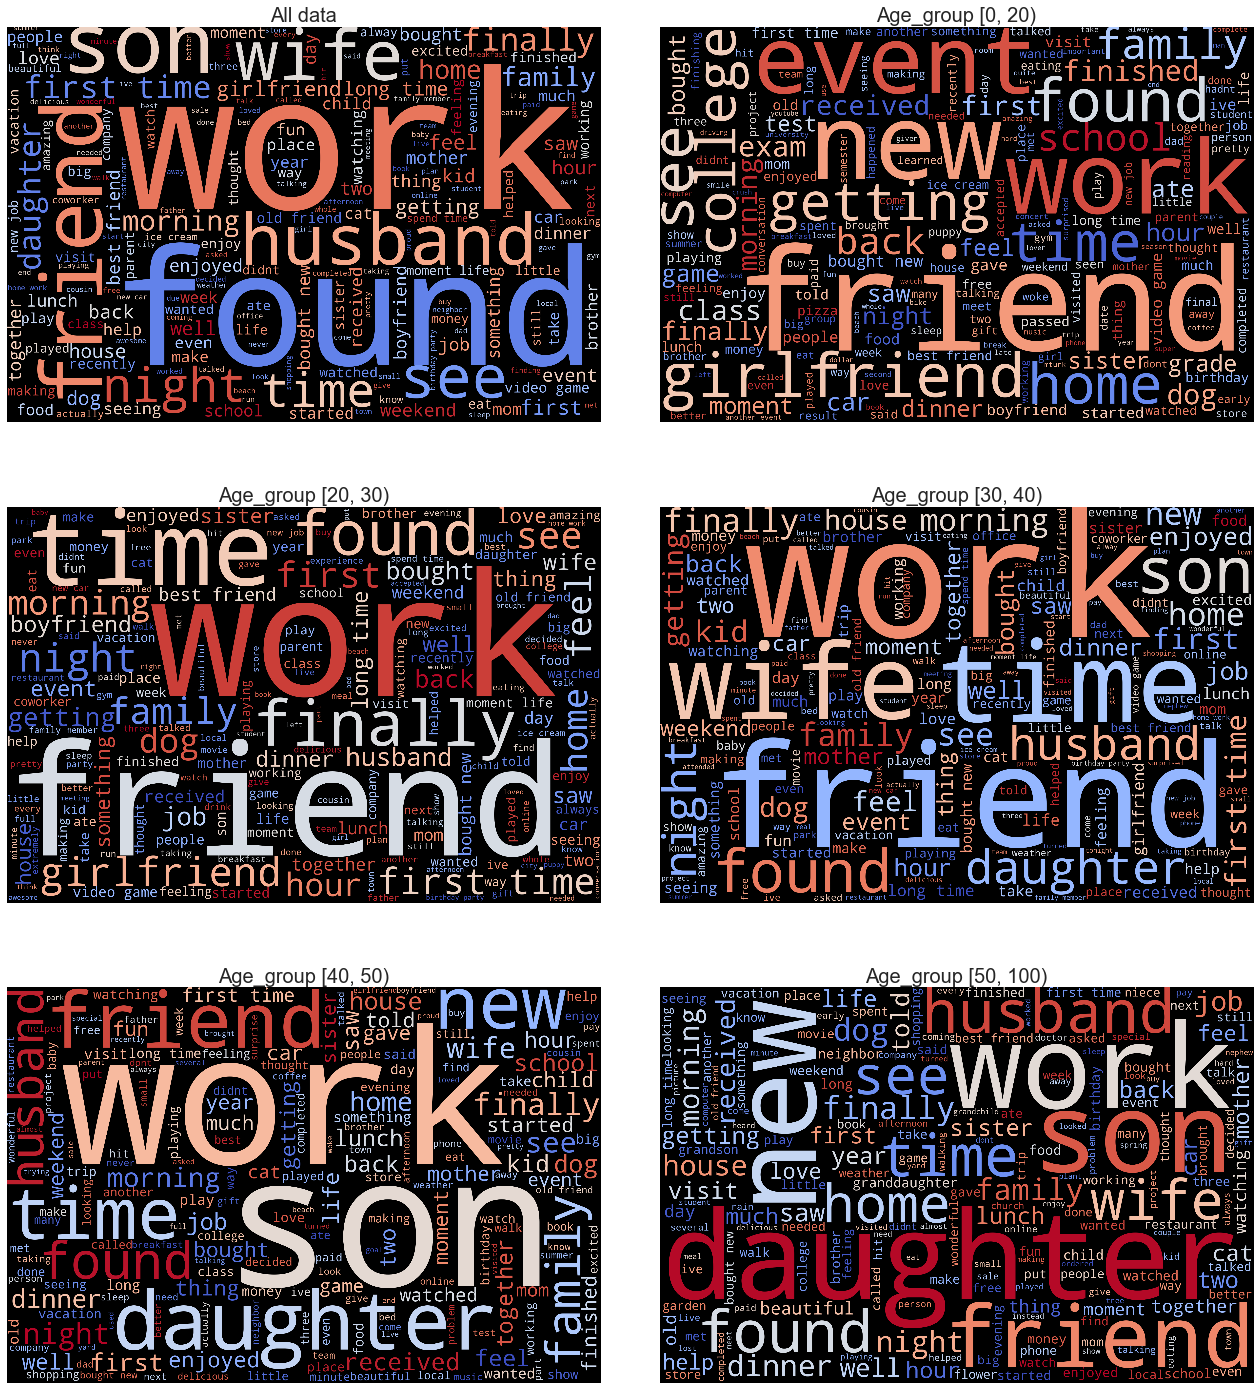

In [91]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,20))
fig.tight_layout()
plt.subplots_adjust(wspace =0.1, hspace =0.1)
ax[0,0].imshow(wc_all, interpolation = 'bilinear')
ax[0,1].imshow(wc_0, interpolation = 'bilinear')
ax[1,0].imshow(wc_1, interpolation = 'bilinear')
ax[1,1].imshow(wc_2, interpolation = 'bilinear')
ax[2,0].imshow(wc_3, interpolation = 'bilinear')
ax[2,1].imshow(wc_4, interpolation = 'bilinear')

ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")
ax[2,0].axis("off")
ax[2,1].axis("off")

ax[0,0].set_title("All data", fontsize=20)
ax[0,1].set_title("Age_group [0, 20)", fontsize=20)
ax[1,0].set_title("Age_group [20, 30)", fontsize=20)
ax[1,1].set_title("Age_group [30, 40)", fontsize=20)
ax[2,0].set_title("Age_group [40, 50)", fontsize=20)
ax[2,1].set_title("Age_group [50, 100)", fontsize=20)

The wordclouds show that key words of happy moments keep changing over our life. When we are young, what makes us happy may be friend. After growing up, work plays a more and more important role. And starting from 30, many people get married and lay more concentration on wife/husband. Then we will have son/daughter and spare more time on them until 50, most happy moments are related to family instead of work.

### Region

In [1155]:
df_clean['region'].value_counts()

America    80153
Asia       17659
Europe      1393
Africa       249
nan          203
Oceania      181
Name: region, dtype: int64

In [34]:
df_amarica = df_clean[df_clean['region'] == 'America']
df_asia = df_clean[df_clean['region'] == 'Asia']
df_europe = df_clean[df_clean['region'] == 'Europe']
df_africa = df_clean[df_clean['region'] == 'Africa']
df_oceania = df_clean[df_clean['region'] == 'Oceania']

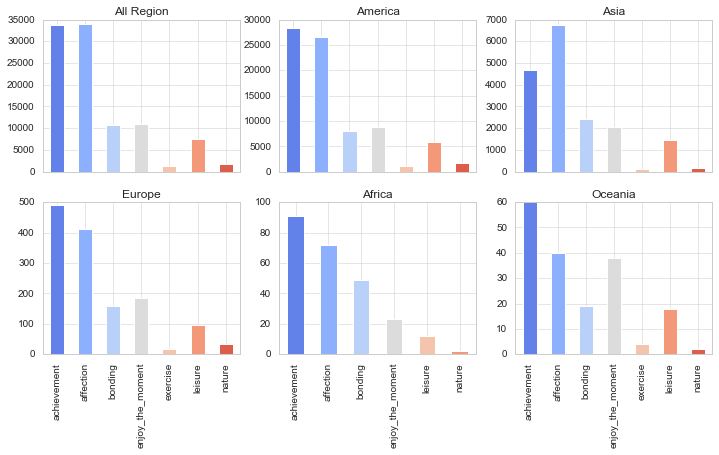

In [65]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
df_clean['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[0, 0], title = "All Region", color=sns.color_palette("coolwarm", 7))
df_amarica['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[0, 1], title = "America", color=sns.color_palette("coolwarm", 7))
df_asia['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[0, 2], title = "Asia", color=sns.color_palette("coolwarm", 7))
df_europe['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[1, 0], title = "Europe", color=sns.color_palette("coolwarm", 7))
df_africa['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[1, 1], title = "Africa", color=sns.color_palette("coolwarm", 7))
df_oceania['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[1, 2], title = "Oceania", color=sns.color_palette("coolwarm", 7))

for ax in axes[0]:
    plt.setp(ax.get_xticklabels(), visible=False)

Although the occurrences for *affection* and *achievement* are very close using all data, this is not the case in most of the regions. 
- People in America tend to feel happy mostly bacause of *affection* and *achievement*. Notice that the total number of submissions in America far outweign other regions and this can explain why it share the same pattern with our whole dataset.
- The distributions of happy moment category are similar in Europe, Africa and Oceania with the number of *achievement* standing out. And comparing with Africa, people in Europe and Oceania earn more happiness from *enjoy_the_moment* than *bonding*. For Africa, there's no happy moments submission regarding to exercise.
- Things are quite different for Asian people, since *affection* is the top one reason to bring happiness rather than *achievement*.

In [92]:
df_america = df_clean[df_clean['region'] == 'America'].astype(str)
df_asia = df_clean[df_clean['region'] == 'Asia'].astype(str)
df_europe = df_clean[df_clean['region'] == 'Europe'].astype(str)
df_africa = df_clean[df_clean['region'] == 'Africa'].astype(str)
df_oceania = df_clean[df_clean['region'] == 'Oceania'].astype(str)

In [93]:
text_amarica = ""
for i in df_america['text'].iteritems():
    text_amarica = text_amarica + "".join(str(x) for x in i[1])
    
text_asia = ""
for i in df_asia['text'].iteritems():
    text_asia = text_asia + "".join(str(x) for x in i[1])
    
text_europe = ""
for i in df_europe['text'].iteritems():
    text_europe = text_europe + "".join(str(x) for x in i[1])

text_africa = ""
for i in df_africa['text'].iteritems():
    text_africa = text_africa + "".join(str(x) for x in i[1])

text_oceania = ""
for i in df_oceania['text'].iteritems():
    text_oceania = text_oceania + "".join(str(x) for x in i[1])

In [94]:
wc_america = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_amarica)

wc_asia = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_asia)

wc_europe = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_europe)

wc_africa = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_africa)

wc_oceania = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_oceania)

Text(0.5, 1, 'Oceania')

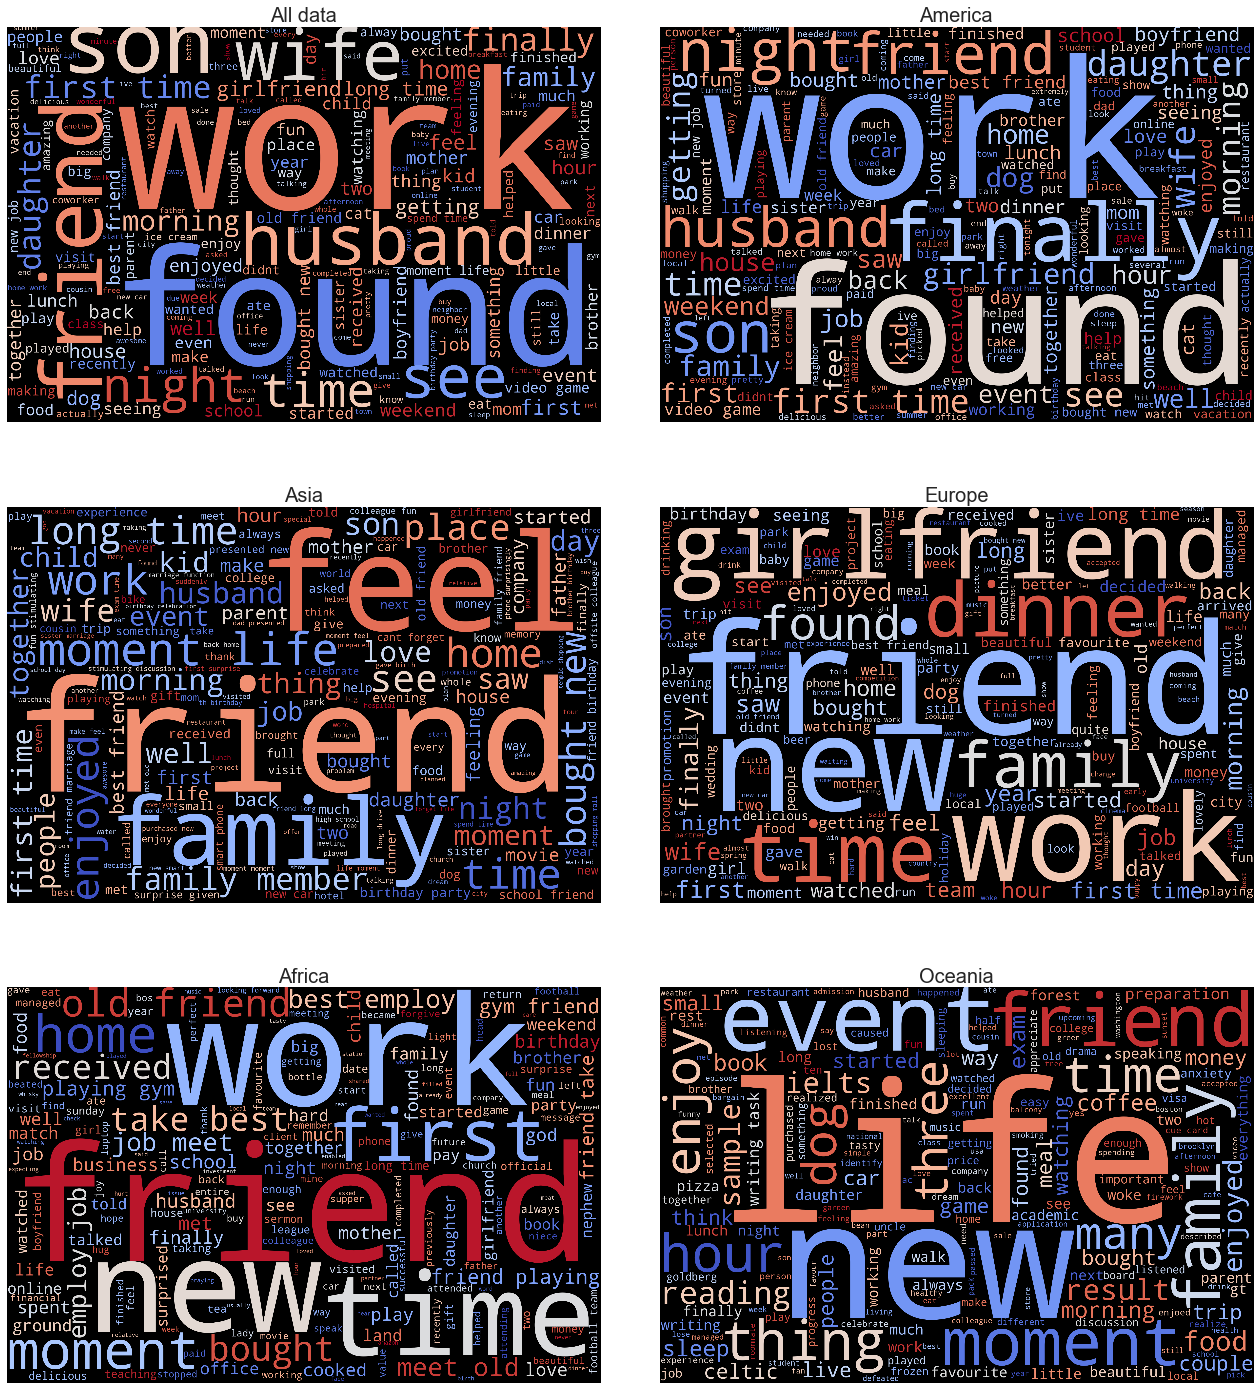

In [95]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,20))
fig.tight_layout()
plt.subplots_adjust(wspace =0.1, hspace =0.1)
ax[0,0].imshow(wc_all, interpolation = 'bilinear')
ax[0,1].imshow(wc_america, interpolation = 'bilinear')
ax[1,0].imshow(wc_asia, interpolation = 'bilinear')
ax[1,1].imshow(wc_europe, interpolation = 'bilinear')
ax[2,0].imshow(wc_africa, interpolation = 'bilinear')
ax[2,1].imshow(wc_oceania, interpolation = 'bilinear')

ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")
ax[2,0].axis("off")
ax[2,1].axis("off")

ax[0,0].set_title("All data", fontsize=20)
ax[0,1].set_title("America", fontsize=20)
ax[1,0].set_title("Asia", fontsize=20)
ax[1,1].set_title("Europe", fontsize=20)
ax[2,0].set_title("Africa", fontsize=20)
ax[2,1].set_title("Oceania", fontsize=20)

- Key words in happy moments submitted by people from America are work and found.
- For Asian people, same as what we found before, they pay more attention on their feelings and relationship between freinds and family.
- People from Europe seem to be more romantic and the word girlfreind is pretty conspicuous except for work and friend.
- Similar to Europe, people in Africa feel happy primarily due to work and friend.
- Life stands out obviously in the wordclous of Oceania. This may suggest that life in Oceania is relatively relaxed and people are not anxious about work. 

### Marital

In [70]:
df_clean['marital'].value_counts()

single       53721
married      41061
divorced      3794
separated      631
widowed        477
Name: marital, dtype: int64

In [108]:
df_single = df_clean[df_clean['marital'] == 'single'].astype(str)
df_married = df_clean[df_clean['marital'] == 'married'].astype(str)
df_divorced = df_clean[df_clean['marital'] == 'divorced'].astype(str)
df_separated = df_clean[df_clean['marital'] == 'separated'].astype(str)
df_widowed = df_clean[df_clean['marital'] == 'widowed'].astype(str)

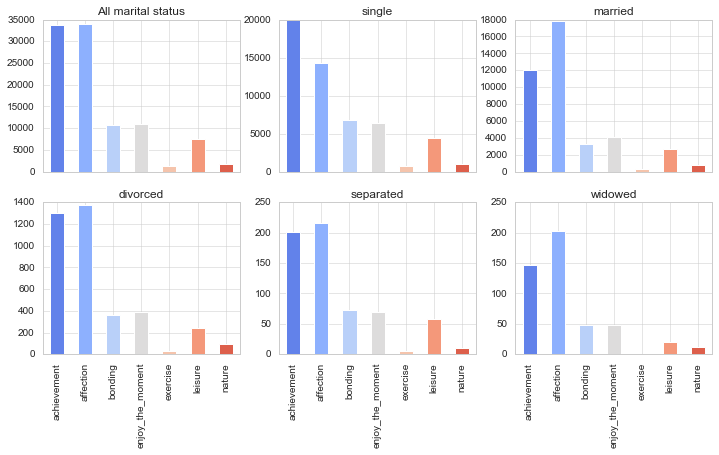

In [109]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
df_clean['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[0, 0], title = "All marital status", color=sns.color_palette("coolwarm", 7))
df_single['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[0, 1], title = "single", color=sns.color_palette("coolwarm", 7))
df_married['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[0, 2], title = "married", color=sns.color_palette("coolwarm", 7))
df_divorced['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[1, 0], title = "divorced", color=sns.color_palette("coolwarm", 7))
df_separated['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[1, 1], title = "separated", color=sns.color_palette("coolwarm", 7))
df_widowed['predicted_category'].value_counts().sort_index().plot(kind='bar', ax = axes[1, 2], title = "widowed", color=sns.color_palette("coolwarm", 7))

for ax in axes[0]:
    plt.setp(ax.get_xticklabels(), visible=False)

Interestingly, only single people feel happy mostly bacause of *achievement*. Those people who have ever been married get happiness mainly from *affection*. The gap between number of submission under topic *affection* and *achievement* is even larger in married and widowed groups.

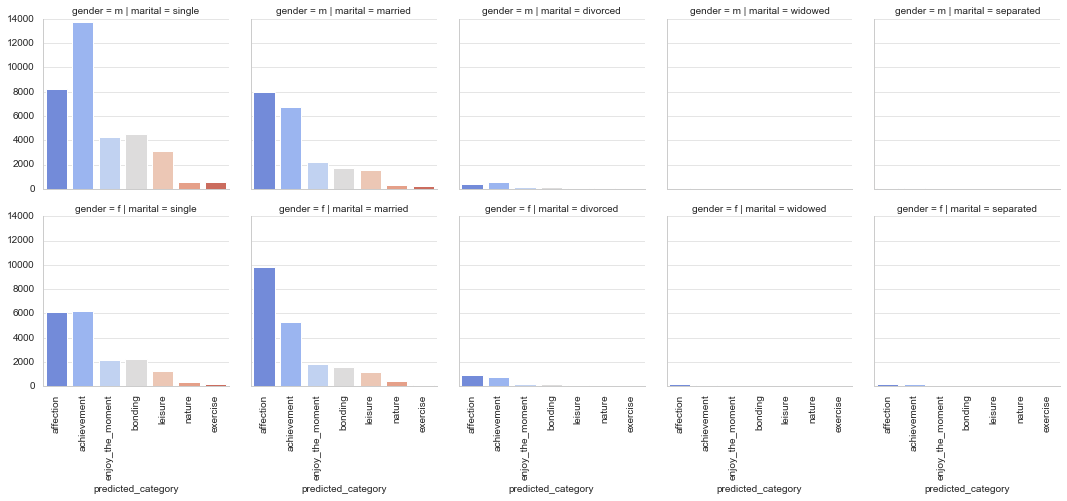

In [110]:
g = sns.FacetGrid(grid_df, col='marital', row='gender')
g = g.map(sns.countplot, 'predicted_category', palette='coolwarm', 
          order=['affection', 'achievement', 'enjoy_the_moment', 'bonding', 'leisure', 'nature', 'exercise'])
for ax in g.axes.flat:
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=90)

Gender also plays a role here. For single males, the happiness resutlting from *achievement* far outweight *affection*. But for single ladies, there's no significant difference.

In [111]:
text_single = ""
for i in df_single['text'].iteritems():
    text_single = text_single + "".join(str(x) for x in i[1])
    
text_married = ""
for i in df_married['text'].iteritems():
    text_married = text_married + "".join(str(x) for x in i[1])
    
text_divorced = ""
for i in df_divorced['text'].iteritems():
    text_divorced = text_divorced + "".join(str(x) for x in i[1])

text_separated = ""
for i in df_separated['text'].iteritems():
    text_separated = text_separated + "".join(str(x) for x in i[1])

text_widowed = ""
for i in df_widowed['text'].iteritems():
    text_widowed = text_widowed + "".join(str(x) for x in i[1])

In [112]:
wc_single = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_single)

wc_married = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_married)

wc_divorced = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_divorced)

wc_separated = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_separated)

wc_widowed = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_widowed)

Text(0.5, 1, 'Widowed')

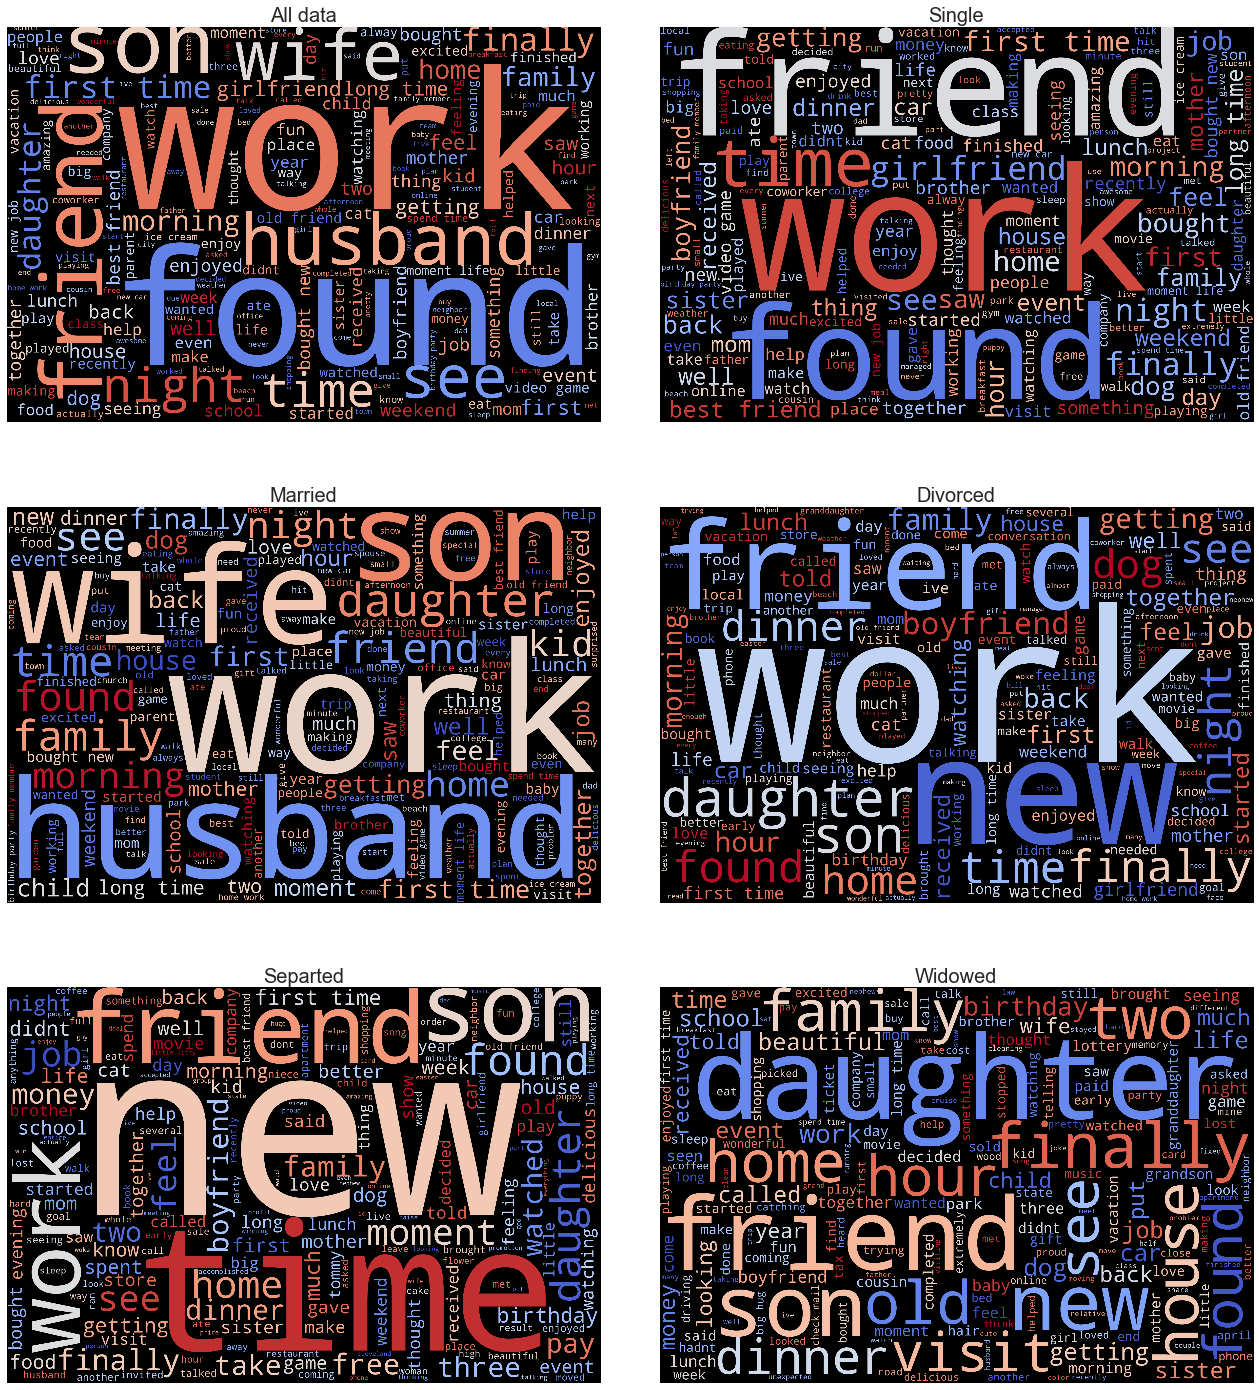

In [113]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,20))
fig.tight_layout()
plt.subplots_adjust(wspace =0.1, hspace =0.1)
ax[0,0].imshow(wc_all, interpolation = 'bilinear')
ax[0,1].imshow(wc_single, interpolation = 'bilinear')
ax[1,0].imshow(wc_married, interpolation = 'bilinear')
ax[1,1].imshow(wc_divorced, interpolation = 'bilinear')
ax[2,0].imshow(wc_separated, interpolation = 'bilinear')
ax[2,1].imshow(wc_widowed, interpolation = 'bilinear')

ax[0,0].axis("off")
ax[0,1].axis("off")
ax[1,0].axis("off")
ax[1,1].axis("off")
ax[2,0].axis("off")
ax[2,1].axis("off")

ax[0,0].set_title("All data", fontsize=20)
ax[0,1].set_title("Single", fontsize=20)
ax[1,0].set_title("Married", fontsize=20)
ax[1,1].set_title("Divorced", fontsize=20)
ax[2,0].set_title("Separted", fontsize=20)
ax[2,1].set_title("Widowed", fontsize=20)

- Single and divorced people seem to have similar pattern. They feel happy mostly from work and friend.
- Understandably, people who get married feel happy mostly due to wife/husband and children.
- The word new catches our eyes in the wordcloud for seapared people. Probably because they are kickster and get happiness from new stuff.
- Widowed people pay more attention on their children.

### Patenthood

In [114]:
df_clean['parenthood'].value_counts()

n    60555
y    39208
Name: parenthood, dtype: int64

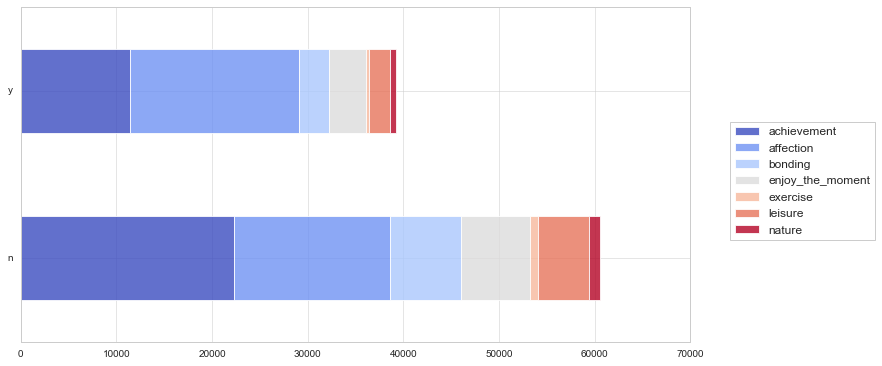

In [115]:
ct_parenthood = pd.crosstab(df_clean['parenthood'], df_clean['predicted_category'])
ct_parenthood.plot.barh(stacked=True, alpha=0.8, figsize=(12,6), cmap='coolwarm')
plt.ylabel('')
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.48))

The main difference lies in that people who have kid feel happy due to *affection* while those who don't get happiness mainly from *achievement*.

In [124]:
df_parent = df_clean[df_clean['parenthood'] == 'y'].astype(str)
df_notparent = df_clean[df_clean['parenthood'] == 'n'].astype(str)

In [125]:
text_parent = ""
for i in df_parent['text'].iteritems():
    text_parent = text_parent + "".join(str(x) for x in i[1])
    
text_notparent = ""
for i in df_notparent['text'].iteritems():
    text_notparent = text_notparent + "".join(str(x) for x in i[1])

In [126]:
wc_parent = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_parent)

wc_notparent = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    colormap = 'coolwarm',
    stopwords = STOPWORDS).generate(text_notparent)

Text(0.5, 1, 'Parenthood: No')

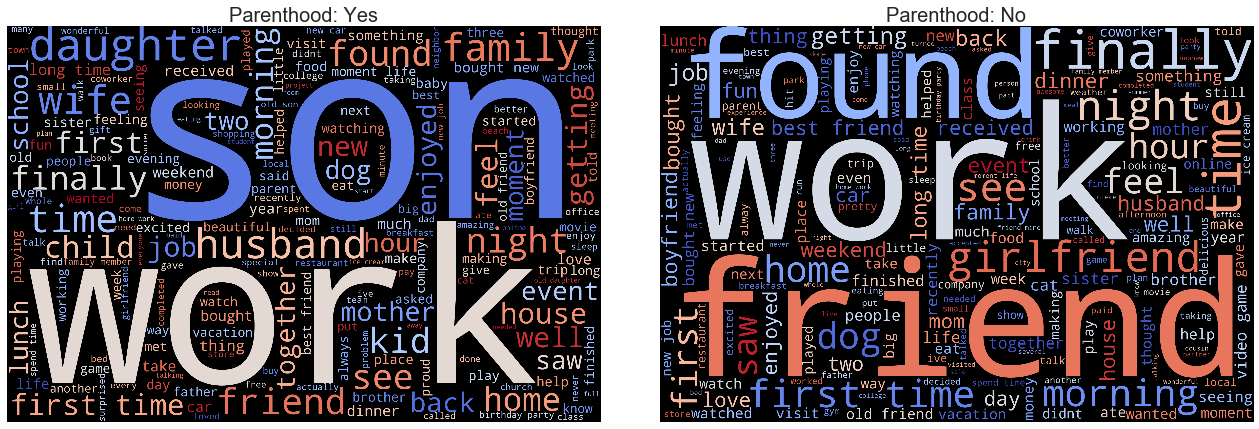

In [128]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,20))
fig.tight_layout()
plt.subplots_adjust(wspace =0.1, hspace =0.1)
ax[0].imshow(wc_parent, interpolation = 'bilinear')
ax[1].imshow(wc_notparent, interpolation = 'bilinear')

ax[0].axis("off")
ax[1].axis("off")

ax[0].set_title("Parenthood: Yes", fontsize=20)
ax[1].set_title("Parenthood: No", fontsize=20)

Work seems to be the mian source of happiness regardless of paranthood or not. However, parenthood does make people pay more attention on kids. And those who don't have kids can spend more time with friends. 

## Part 3: Classification model

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
import xgboost
import pandas as pd

In [3]:
df_original = pd.read_csv('../data/cleaned_hm.csv')

In [4]:
text = df_original['cleaned_hm']
label = df_original['predicted_category']

In [5]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(text, label, test_size=0.3, random_state=0)

encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

### Feature engineer
#### 1. CountVectorizer

In [6]:
count_vect = CountVectorizer(analyzer='word')
count_vect.fit(text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [7]:
Xtrain_count = count_vect.transform(X_train)
Xtest_count = count_vect.transform(X_test)

#### 2. TF-IDF
- word level

In [8]:
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=5000)
tfidf_vect.fit(text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [9]:
Xtrain_tfidf = tfidf_vect.transform(X_train)
Xtest_tfidf = tfidf_vect.transform(X_test)

- ngram

In [16]:
tfidf_vect_ngram = TfidfVectorizer(analyzer='word', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram.fit(text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [17]:
Xtrain_tfidf_ngram = tfidf_vect_ngram.transform(X_train)
Xtest_tfidf_ngram = tfidf_vect_ngram.transform(X_test)

- character 

In [18]:
tfidf_vect_ngram_chars = TfidfVectorizer(analyzer='char', ngram_range=(2,3), max_features=5000)
tfidf_vect_ngram_chars.fit(text)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(2, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [19]:
Xtrain_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_train)
Xtest_tfidf_ngram_chars = tfidf_vect_ngram_chars.transform(X_test)

### Models

In [12]:
def train_model(classifier, feature_vector_train, label, feature_vector_test):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_test)
    return metrics.accuracy_score(predictions, y_test)

#### 1. Naive Bayes

In [173]:
accuracy_cont = train_model(naive_bayes.MultinomialNB(), Xtrain_count, y_train, Xtest_count)
accuracy_tfidf_word = train_model(naive_bayes.MultinomialNB(), Xtrain_tfidf, y_train, Xtest_tfidf)
accuracy_tfidf_ngram = train_model(naive_bayes.MultinomialNB(), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)
accuracy_tfidf_chars = train_model(naive_bayes.MultinomialNB(), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)
print("Naive Bayes, Count Vectors: ", accuracy_cont)
print("Naive Bayes, WordLevel TF-IDF: ", accuracy_tfidf_word)
print("Naive Bayes, ngram TF-IDF: ", accuracy_tfidf_ngram)
print("Naive Bayes, CharsLevel TF-IDF: ", accuracy_tfidf_chars)

Naive Bayes, Count Vectors:  0.822863403944485
Naive Bayes, WordLevel TF-IDF:  0.7843482302941762
Naive Bayes, ngram TF-IDF:  0.7411182681452951
Naive Bayes, CharsLevel TF-IDF:  0.7695066073444452


#### 2. Logistic Regression

In [183]:
accuracy_cont = train_model(linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=150), Xtrain_count, y_train, Xtest_count)
accuracy_tfidf_word = train_model(linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=5000), Xtrain_tfidf, y_train, Xtest_tfidf)
accuracy_tfidf_ngram = train_model(linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=200), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)
accuracy_tfidf_chars = train_model(linear_model.LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)
print("Logistic Regression, Count Vectors: ", accuracy_cont)
print("Logistic Regression, WordLevel TF-IDF: ", accuracy_tfidf_word)
print("Logistic Regression, ngram TF-IDF: ", accuracy_tfidf_ngram)
print("Logistic Regression, CharsLevel TF-IDF: ", accuracy_tfidf_chars)

/Users/wangxinquan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/wangxinquan/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Logistic Regression, Count Vectors:  0.9382097084799788
Logistic Regression, WordLevel TF-IDF:  0.9239325320406402
Logistic Regression, ngram TF-IDF:  0.8027425459857892
Logistic Regression, CharsLevel TF-IDF:  0.8781459592270403


#### 3. SVM

In [25]:
accuracy_cont = train_model(svm.SVC(gamma='scale'), Xtrain_count, y_train, Xtest_count)
accuracy_tfidf_word = train_model(svm.SVC(gamma='scale'), Xtrain_tfidf, y_train, Xtest_tfidf)
accuracy_tfidf_ngram = train_model(svm.SVC(gamma='scale'), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)
accuracy_tfidf_chars = train_model(svm.SVC(gamma='scale'), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)
print("SVM, Count Vectors: ", accuracy_cont)
print("SVM, WordLevel TF-IDF: ", accuracy_tfidf_word)
print("SVM, ngram TF-IDF: ", accuracy_tfidf_ngram)
print("SVM, CharsLevel TF-IDF: ", accuracy_tfidf_chars)

SVM, Count Vectors:  0.8932727694705083
SVM Regression, WordLevel TF-IDF:  0.922184277709625
SVM, ngram TF-IDF:  0.8005702728689367
SVM, CharsLevel TF-IDF:  0.8881005271708498


#### 4. Random Forest

In [16]:
accuracy_cont = train_model(ensemble.RandomForestClassifier(n_estimators=10), Xtrain_count, y_train, Xtest_count)
accuracy_tfidf_word = train_model(ensemble.RandomForestClassifier(n_estimators=10), Xtrain_tfidf, y_train, Xtest_tfidf)
accuracy_tfidf_ngram = train_model(ensemble.RandomForestClassifier(n_estimators=10), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)
accuracy_tfidf_chars = train_model(ensemble.RandomForestClassifier(n_estimators=10), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)
print("Random Forest, Count Vectors: ", accuracy_cont)
print("Random Forest, WordLevel TF-IDF: ", accuracy_tfidf_word)
print("Random Forest, ngram TF-IDF: ", accuracy_tfidf_ngram)
print("Random Forest, CharsLevel TF-IDF: ", accuracy_tfidf_chars)

Random Forest, Count Vectors:  0.805941447564736
Random Forest, WordLevel TF-IDF:  0.8126719936341633
Random Forest, ngram TF-IDF:  0.7621100096150658
Random Forest, CharsLevel TF-IDF:  0.7717913862272471


#### 5. Boosting

In [14]:
accuracy_cont = train_model(xgboost.XGBClassifier(), Xtrain_count, y_train, Xtest_count)

In [15]:
accuracy_tfidf_word = train_model(xgboost.XGBClassifier(), Xtrain_tfidf, y_train, Xtest_tfidf)

In [20]:
accuracy_tfidf_ngram = train_model(xgboost.XGBClassifier(), Xtrain_tfidf_ngram, y_train, Xtest_tfidf_ngram)

In [21]:
accuracy_tfidf_chars = train_model(xgboost.XGBClassifier(), Xtrain_tfidf_ngram_chars, y_train, Xtest_tfidf_ngram_chars)

In [22]:
print("Boosting, Count Vectors: ", accuracy_cont)
print("Boosting, WordLevel TF-IDF: ", accuracy_tfidf_word)
print("Boosting, ngram TF-IDF: ", accuracy_tfidf_ngram)
print("Boosting, CharsLevel TF-IDF: ", accuracy_tfidf_chars)

Boosting, Count Vectors:  0.7886674844998508
Boosting, WordLevel TF-IDF:  0.7863797619442326
Boosting, ngram TF-IDF:  0.672059944962037
Boosting, CharsLevel TF-IDF:  0.8007692052650774
